Loading World Bank dataset files...
✓ Metadata loaded successfully: 265 countries
Metadata columns: ['Country Code', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5']
Income groups in dataset: ['High income', 'Low income', 'Lower middle income', 'Upper middle income']
✓ Climate data loaded successfully: 13566 rows, 70 columns
Dataset contains 51 indicators for 266 countries
Data years: 1960 to 2024

Sample of available indicators:
  1. Urban population (% of total population)
  2. Urban population
  3. Urban population growth (annual %)
  4. Population, total
  5. Population growth (annual %)
  6. Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)
  7. Prevalence of underweight, weight for age (% of children under 5)
  8. Community health workers (per 1,000 people)
  9. Mortality rate, under-5 (per 1,000 live births)
  10. Primary completion rate, total (% of relevant age group)
  ... and 41 more indicators

Found 7 climate-related indicators:
  1. Dr

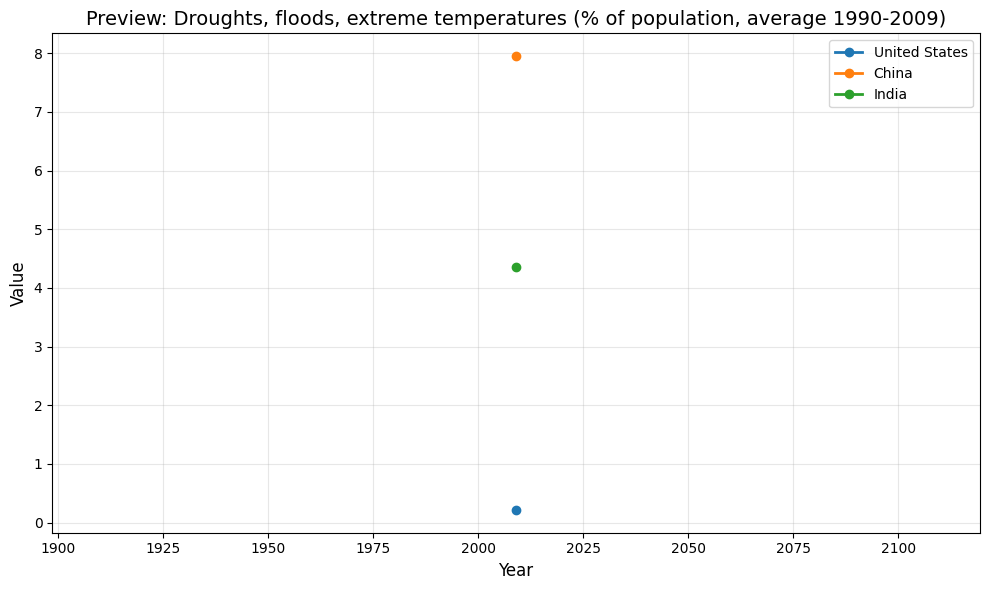

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset files
print("Loading World Bank dataset files...")

# Load metadata
try:
    metadata_df = pd.read_csv('Metadata_Country_API_19_DS2_en_csv_v2_21028.csv')
    print(f"✓ Metadata loaded successfully: {len(metadata_df)} countries")
    
    # Display metadata columns
    print(f"Metadata columns: {metadata_df.columns.tolist()}")
    
    # Check income groups if available
    if 'IncomeGroup' in metadata_df.columns:
        income_groups = metadata_df['IncomeGroup'].dropna().unique()
        print(f"Income groups in dataset: {income_groups.tolist()}")
except Exception as e:
    print(f"✗ Error loading metadata file: {e}")
    metadata_df = None

# Load climate data
try:
    # World Bank data typically has metadata rows at the top
    climate_df = pd.read_csv('API_19_DS2_en_csv_v2_21028.csv', skiprows=4)
    print(f"✓ Climate data loaded successfully: {len(climate_df)} rows, {len(climate_df.columns)} columns")
    
    # Display important columns
    if 'Indicator Name' in climate_df.columns and 'Country Name' in climate_df.columns:
        n_indicators = climate_df['Indicator Name'].nunique()
        n_countries = climate_df['Country Name'].nunique()
        print(f"Dataset contains {n_indicators} indicators for {n_countries} countries")
        
        # Find year columns (those that are numeric)
        year_cols = [col for col in climate_df.columns if str(col).isdigit()]
        year_cols.sort()
        
        if year_cols:
            print(f"Data years: {year_cols[0]} to {year_cols[-1]}")
    
    # Print the first few indicators to see what's available
    indicators = climate_df['Indicator Name'].unique()
    print("\nSample of available indicators:")
    for i, indicator in enumerate(indicators[:10]):
        print(f"  {i+1}. {indicator}")
    print(f"  ... and {len(indicators) - 10} more indicators")
except Exception as e:
    print(f"✗ Error loading climate data file: {e}")
    climate_df = None

if climate_df is not None:
    # Identify climate change related indicators
    climate_keywords = ['climate', 'temperature', 'carbon', 'co2', 'emission', 'greenhouse', 
                        'renewable', 'energy', 'fossil', 'methane', 'environment']
    
    climate_indicators = []
    for indicator in indicators:
        if any(keyword in str(indicator).lower() for keyword in climate_keywords):
            climate_indicators.append(indicator)
    
    print(f"\nFound {len(climate_indicators)} climate-related indicators:")
    for i, indicator in enumerate(climate_indicators):
        print(f"  {i+1}. {indicator}")
    
    # Analyze data coverage for climate indicators
    print("\nAnalyzing data coverage for climate indicators...")
    indicator_coverage = {}
    
    for indicator in climate_indicators:
        indicator_data = climate_df[climate_df['Indicator Name'] == indicator]
        
        # Count non-null values across all years
        total_cells = len(indicator_data) * len(year_cols)
        non_null_cells = indicator_data[year_cols].notna().sum().sum()
        coverage_pct = (non_null_cells / total_cells) * 100 if total_cells > 0 else 0
        
        indicator_coverage[indicator] = {
            'total_cells': total_cells,
            'non_null_cells': non_null_cells,
            'coverage_pct': coverage_pct
        }
    
    # Sort indicators by coverage
    sorted_indicators = sorted(indicator_coverage.items(), 
                              key=lambda x: x[1]['coverage_pct'], 
                              reverse=True)
    
    print("\nClimate indicators ranked by data coverage:")
    for i, (indicator, stats) in enumerate(sorted_indicators[:10]):
        print(f"  {i+1}. {indicator}: {stats['coverage_pct']:.1f}% coverage")
    
    # Identify best indicators for our visualizations
    print("\nRecommended indicators for visualizations:")
    
    # For temperature trend
    temp_indicators = [ind for ind in climate_indicators 
                      if 'temperature' in str(ind).lower()]
    if temp_indicators:
        print(f"  Temperature visualization: {temp_indicators[0]}")
    else:
        print("  Temperature visualization: No specific temperature indicator found")
    
    # For emissions
    emission_indicators = [ind for ind in climate_indicators 
                          if 'co2' in str(ind).lower() or 'emission' in str(ind).lower()]
    if emission_indicators:
        print(f"  Emissions visualization: {emission_indicators[0]}")
    else:
        print("  Emissions visualization: No specific emissions indicator found")
    
    # For renewable energy
    renewable_indicators = [ind for ind in climate_indicators 
                           if 'renewable' in str(ind).lower()]
    if renewable_indicators:
        print(f"  Renewable energy visualization: {renewable_indicators[0]}")
    else:
        print("  Renewable energy visualization: No specific renewable energy indicator found")
    
    # For GDP/economic data
    gdp_indicators = [ind for ind in indicators 
                     if 'gdp' in str(ind).lower()]
    if gdp_indicators:
        print(f"  Economic data: {gdp_indicators[0]}")
    else:
        print("  Economic data: No specific GDP indicator found")
    
    # Check data for a few major countries
    major_countries = ['World', 'United States', 'China', 'European Union', 'India', 'Japan', 'Brazil']
    available_countries = []
    
    for country in major_countries:
        if country in climate_df['Country Name'].values:
            available_countries.append(country)
    
    if available_countries:
        print(f"\nMajor countries available in dataset: {available_countries}")
    
    # Create a preview visualization of one climate indicator
    if climate_indicators and len(available_countries) > 0:
        preview_indicator = climate_indicators[0]
        preview_data = climate_df[climate_df['Indicator Name'] == preview_indicator]
        
        plt.figure(figsize=(10, 6))
        
        for country in available_countries[:5]:  # Plot up to 5 countries
            country_data = preview_data[preview_data['Country Name'] == country]
            if not country_data.empty:
                # Create year/value pairs excluding NaN values
                x = []
                y = []
                
                for year in year_cols:
                    if year in country_data.columns:
                        value = country_data[year].iloc[0]
                        if pd.notna(value):
                            x.append(int(year))
                            y.append(value)
                
                if x and y:  # Only plot if we have data
                    plt.plot(x, y, marker='o', linewidth=2, label=country)
        
        plt.title(f"Preview: {preview_indicator}", fontsize=14)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()